# Select representative decomposition results, sm=5e6

This notebook follows the same procedure as `select_representative_run.ipynb`.

In [1]:
import os
import glob
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import xarray as xr
import dill

## Load MVBS data

In [2]:
MVBS_PCP_path = '../data/'
MVBS_rpca_file = '20150817-20151017_MVBS_time_Sv_rangeBin5_all_corrected_rpca.nc'

MVBS_rpca = xr.open_dataset(os.path.join(MVBS_PCP_path, MVBS_rpca_file))
low_rank = MVBS_rpca['low_rank']
n_observations, n_frequencies, n_depth_levels, n_pings = low_rank.shape

In [3]:
low_rank = low_rank.values.reshape([n_observations,-1])

In [4]:
low_rank_nonneg = low_rank - low_rank.min()
low_rank_nonneg.shape

(62, 15984)

## Get all filenames

Rank=1 results:

In [5]:
r1_path = '../data/precalc_tsnmf/smoothness_sweep_dict/sm5e6_sp0_rank1only/'
r1_fname = sorted(glob.glob(os.path.join(r1_path, '*.pkl')))

Rank=2-9 filenames:

In [6]:
other_path = '../data/precalc_tsnmf/smoothness_sweep_dict/sm5e6_sp0/'
other_fname = sorted(glob.glob(os.path.join(other_path, '*.pkl')))

In [7]:
# Combine all fnames
all_fname = r1_fname + other_fname

In [8]:
# Set all rank
rank_all = np.arange(1,10)

## MSE and smoothness regularization cost (SMC)

### Functions to calculate mse and smoothness cost

In [9]:
def calc_mse(output_holder, fname_list, data):
    """
    Calculate MSE for each model.

    Parameters
    ----------
    output_holder
        list to hold all MSE
    fname_list
        list of filename containing tsNMF results
    data
        data before decomposition
        `data = low_rank_nonneg.T` for the original data.    
        `data = data_shuffle_axday` for the shuffled data.
    """
    for ff in fname_list:
        with open(ff,'rb') as openfile:
            x = dill.load(openfile)
        mse = []
        for mm in x:
            mse.append(np.linalg.norm(data - mm['W']@mm['H'])**2/low_rank_nonneg.size)
        output_holder += mse
    return output_holder

In [10]:
def calc_smc(output_holder, fname_list):
    """
    Calculate sparsity reg cost from each model.
    
    Parameters
    ----------
    output_holder
        list to hold all MSE
    fname_list
        list of filename containing tsNMF results
    """
    for ff in fname_list:
        with open(ff,'rb') as openfile:
            x = dill.load(openfile)
        smc = []
        for mm in x:
            smc.append(np.linalg.norm(mm['H'][:,1:] - mm['H'][:,:-1])**2)
        output_holder += smc
    return output_holder

### Compute MSE and SMC

In [11]:
mse_ori = calc_mse([], all_fname, data=low_rank_nonneg.T)
smc_ori = calc_smc([], all_fname)

In [12]:
# Sanity check: dimension should all be 320*9
len(mse_ori), len(smc_ori)

(2880, 2880)

Reshape these results for the next step:

In [13]:
mse_ori = np.array(mse_ori).reshape((len(rank_all),-1))
smc_ori = np.array(smc_ori).reshape((len(rank_all),-1))

In [14]:
# Sanity check: should be 9x320 = number of rank x number of runs per rank
mse_ori.shape

(9, 320)

### Distribution of MSE and SMC

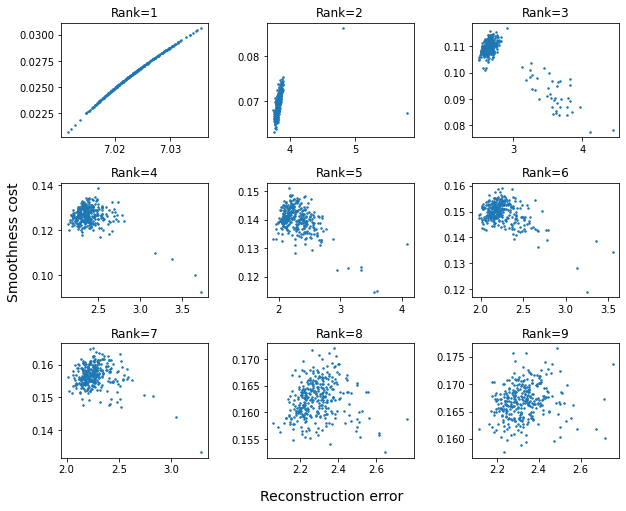

In [15]:
fig, ax = plt.subplots(3,3,figsize=(10,8))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
for seq,rr in enumerate(rank_all):
    samples = np.vstack((mse_ori[seq,:], smc_ori[seq,:])).T
    axseq = np.unravel_index(seq,(3,3))
    ax[axseq].plot(samples[:,0], samples[:,1], '.', markersize=3)
    ax[axseq].set_title('Rank=%d'%rr)
fig.text(0.5, 0.05, 'Reconstruction error', fontsize=14, ha='center')
fig.text(0.05, 0.5, 'Smoothness cost', fontsize=14, va='center', rotation='vertical')
plt.show()

Seems that for rank=2-7 there are some outliers that we might want to remove when selecting the runs.

### k-means clustering to separate outliers

In [16]:
from sklearn.cluster import KMeans

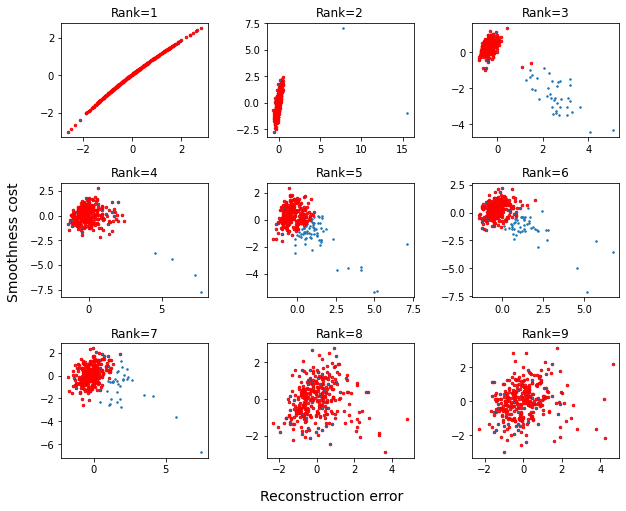

In [17]:
runs_wanted = []
fig, ax = plt.subplots(3,3,figsize=(10,8))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
for seq,rr in enumerate(rank_all):
    samples = np.vstack((mse_ori[seq,:], smc_ori[seq,:])).T
    samples = (samples - samples.mean(axis=0)) / samples.std(axis=0)  # standardize
    if rr in np.arange(2,8):
        kmeans = KMeans(n_clusters=2, random_state=0).fit(samples)
    else:
        kmeans = KMeans(n_clusters=1, random_state=0).fit(samples)
    which_is_good = kmeans.cluster_centers_[:,0].argmin(axis=0)
    runs_wanted.append(kmeans.labels_==which_is_good)
    axseq = np.unravel_index(seq,(3,3))
    ax[axseq].plot(samples[:,0], samples[:,1], '.', markersize=3)
    ax[axseq].plot(samples[kmeans.labels_==which_is_good, 0], 
                   samples[kmeans.labels_==which_is_good, 1], 
                   'r.', markerfacecolor='none', markersize=5)
    ax[axseq].set_title('Rank=%d'%rr)
fig.text(0.5, 0.05, 'Reconstruction error', fontsize=14, ha='center')
fig.text(0.05, 0.5, 'Smoothness cost', fontsize=14, va='center', rotation='vertical')
plt.show()

We can see that the clustering separates out the outliers pretty well for rank=2-4. For rank5-7 the cluster boundary is not perfect, but since we're focusing on rank=3 results here, let's proceed with these selections.

### Reshape to according entries in the pre-calculated tsNMF results files

In [18]:
num_files_per_rank = 8
num_runs_per_file = 40

In [19]:
[np.nonzero(x)[0].shape[0] for x in runs_wanted]

[320, 318, 282, 316, 252, 271, 287, 320, 320]

In [20]:
def reshape_runs_to_per_file(runs_all):
    runs_each_file = np.array(runs_all).reshape(-1).reshape(-1,num_runs_per_file)
    runs_each_file = [np.nonzero(runs_each_file[x,:])[0] for x in range(runs_each_file.shape[0])]
    return runs_each_file

In [21]:
runs_wanted_per_file = reshape_runs_to_per_file(runs_wanted)

In [22]:
# Sanity check: should have 72 files in total
len(runs_wanted_per_file)

72

## Gather info from selected tsNMF runs

In [23]:
def gather_H_and_W(runs_wanted_per_file, container, fname, verbose=False):
    """
    Get H and W from the selected runs and put it into the container dictionary.
    """
    
    for seq_file,ff in enumerate(fname):
        with open(ff,'rb') as openfile:
            x = dill.load(openfile)

        # Start fresh H and W lists for new rank
        #  e.g., each rank has 8 files, so seq_f%8=0 means the beginning of a rank
        if seq_file % num_files_per_rank == 0:  
            H, W, fn_ln = [], [], []
            if verbose:
                print('file %0d: '%seq_file +'starting new rank')

        # Collect H from good runs in file ff
        if verbose:
            print('gather H and W in file: %s' % os.path.basename(ff))
        for seq_line,mm in enumerate(x):  # loop through all results in this file
            if seq_line in runs_wanted_per_file[seq_file]:
                H.append(mm['H'])
                W.append(mm['W'])
                fn_ln.append([seq_file, seq_line])
        if verbose:
            print('   total %d Hs and Ws gathered' % len(H))

        # Save H and W lists for this rank to master dict
        if (seq_file+1) % num_files_per_rank == 0:
            container['H'].append(H)
            container['W'].append(W)
            container['filenum_linenum'].append(fn_ln)
            if verbose:
                print('file %0d: '%seq_file +'ending this rank')
                print('---------------------------------------')

In [24]:
# Get MSE and SMC from the good runs
tsNMF_results = defaultdict(list)

for rr in range(len(rank_all)):
    tsNMF_results['MSE'].append(mse_ori[rr, runs_wanted[rr]])
    tsNMF_results['SMC'].append(smc_ori[rr, runs_wanted[rr]])

In [25]:
# Gather H and W from the good runs
gather_H_and_W(runs_wanted_per_file, tsNMF_results, all_fname, verbose=True)

file 0: starting new rank
gather H and W in file: ssNMF_sm5e+06_sp0.0_batch01.pkl
   total 40 Hs and Ws gathered
gather H and W in file: ssNMF_sm5e+06_sp0.0_batch02.pkl
   total 80 Hs and Ws gathered
gather H and W in file: ssNMF_sm5e+06_sp0.0_batch03.pkl
   total 120 Hs and Ws gathered
gather H and W in file: ssNMF_sm5e+06_sp0.0_batch04.pkl
   total 160 Hs and Ws gathered
gather H and W in file: ssNMF_sm5e+06_sp0.0_batch05.pkl
   total 200 Hs and Ws gathered
gather H and W in file: ssNMF_sm5e+06_sp0.0_batch06.pkl
   total 240 Hs and Ws gathered
gather H and W in file: ssNMF_sm5e+06_sp0.0_batch07.pkl
   total 280 Hs and Ws gathered
gather H and W in file: ssNMF_sm5e+06_sp0.0_batch08.pkl
   total 320 Hs and Ws gathered
file 7: ending this rank
---------------------------------------
file 8: starting new rank
gather H and W in file: ssNMF_sm5e+06_sp0.0_batch01.pkl
   total 40 Hs and Ws gathered
gather H and W in file: ssNMF_sm5e+06_sp0.0_batch02.pkl
   total 80 Hs and Ws gathered
gather 

In [26]:
# Sanity check: should have 9 elements in this key
len(tsNMF_results['H'])

9

### Keep track of the original line number in the parameter file

`tsNMF_results['filenum_linenum']` contains the filenum and linenum matching information to figure out the random seed used for a specific run. Let's calculate that below.

In [27]:
# Sanity check that the number of entries in filenum_linenum is the same as MSE
len(tsNMF_results['filenum_linenum'][2]) == len(tsNMF_results['MSE'][2])

True

In [28]:
# Find original line number in param file
num_files_per_rank = 8
num_lines_per_file = 40

for seq, fn_ln in enumerate(tsNMF_results['filenum_linenum']):  # loop through all rank
    fn_ln = np.array(fn_ln)  # convert to np.array
    ln = (fn_ln[:,0] - seq*num_files_per_rank)*num_lines_per_file + fn_ln[:,1]
    tsNMF_results['filenum_linenum_original'].append(ln)

### Normalize H and W

In [29]:
for H_rank,W_rank in zip(tsNMF_results['H'], tsNMF_results['W']):
    H_multW, W_divW = [], []
    for H,W in zip(H_rank, W_rank):
        H_multW.append((H.T*np.linalg.norm(W, axis=0)).T)
        W_divW.append(W/np.linalg.norm(W, axis=0))
    tsNMF_results['H_multW'].append(H_multW)
    tsNMF_results['W_divW'].append(W_divW)

## NMF with `nndsvd` initialization

In [30]:
from sklearn.decomposition import NMF

In [31]:
import warnings
warnings.filterwarnings('ignore')

In [32]:
# run classic NMF
NMF_nndsvd = NMF(n_components=3, init='nndsvd' , max_iter=5000)
H_nndsvd = NMF_nndsvd.fit_transform(low_rank_nonneg)
W_nndsvd = NMF_nndsvd.components_

## Matching components

In [33]:
def match_factors_by_H(Hs, NMF_Hs=None):
    """Ordering the components based on H curves.
    """
    sample_num, rank_num, _ = Hs.shape
    new_idx = np.zeros((sample_num, rank_num))
    if NMF_Hs is not None:
        Hs_ref = NMF_Hs
    else:
        Hs_ref = Hs[0,:,:].T
    for k in range(sample_num):  # loop through all runs
        rho = np.corrcoef(Hs_ref.T, Hs[k,:,:])[:rank_num,rank_num:]
        index = [0 for r in range(rank_num)]
        for p in range(rank_num):
            index_max = np.argmax(rho)
            # index = np.argsort(rho, axis=1)
            i,j = np.unravel_index(index_max,(rank_num,rank_num))
            rho[:,j] = -2
            rho[i,:] = -2
            index[i] = j
        new_idx[k,:] = index
    return new_idx.astype(int)

### Matching components based on classic NMF

In [34]:
def match_factors_by_H(Hs, Hs_ref):
    """Order Hs based on Hs_ref.
    """
    rank_num, _ = Hs.shape
    rho = np.corrcoef(Hs_ref, Hs)[:rank_num,rank_num:]
    index = [0 for r in range(rank_num)]
    for p in range(rank_num):
        index_max = np.argmax(rho)
        # index = np.argsort(rho, axis=1)
        i,j = np.unravel_index(index_max,(rank_num,rank_num))
        rho[:,j] = -2
        rho[i,:] = -2
        index[i] = j
    
    return np.array(index).astype(int)

In [35]:
rr = 3     # rank=3
r_idx = 2

In [36]:
match_idx_by_H_NMF = []
for hh in tsNMF_results['H'][r_idx]:
    match_idx_by_H_NMF.append(match_factors_by_H(hh, Hs_ref=H_nndsvd.T))

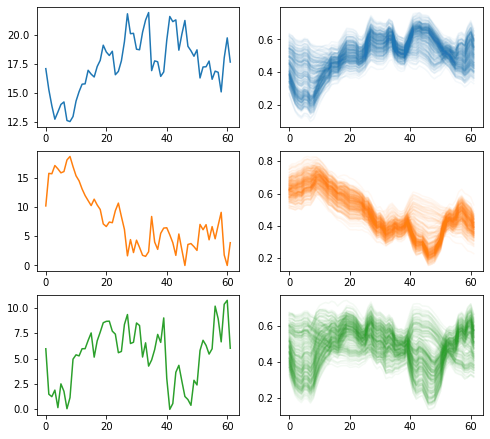

In [37]:
# Plot matchin for inspection
fig,ax = plt.subplots(rr, 2, figsize=(8,2.5*rr))
Hs = np.array(tsNMF_results['H'][r_idx])  # tsNMF results
for rank_seq in range(rr):
    ax[rank_seq, 0].plot(H_nndsvd[:, rank_seq], 'C%d'%rank_seq)  # NMF results
    for run_seq in range(len(match_idx_by_H_NMF)):
        ax[rank_seq, 1].plot(Hs[run_seq, match_idx_by_H_NMF[run_seq]][rank_seq,:], 'C%d'%rank_seq, alpha=0.05)
plt.show()

## Select rank=3 run

In [38]:
rank_to_check = 3
r_idx = np.nonzero(rank_to_check==rank_all)[0][0]
run_idx_sorted = np.argsort(tsNMF_results['MSE'][r_idx])

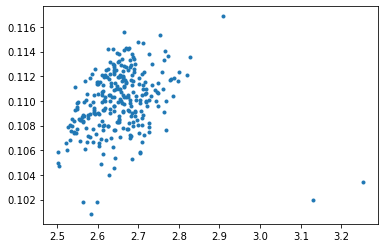

In [39]:
# Check MSE vs SMC spread
plt.plot(tsNMF_results['MSE'][r_idx], 
         tsNMF_results['SMC'][r_idx], '.')
plt.show()

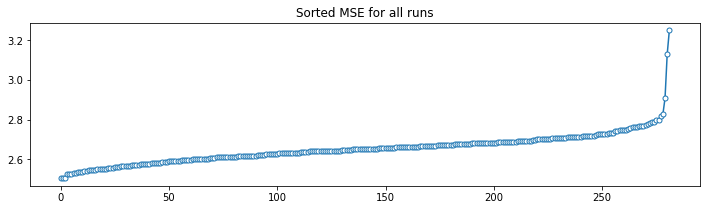

In [40]:
# Sanity check to make sure the MSE is sorted
plt.figure(figsize=(12,3))
plt.plot(tsNMF_results['MSE'][r_idx][run_idx_sorted], '.-', markersize=10, markerfacecolor='w')
plt.title('Sorted MSE for all runs')
# plt.xlim(-1,50)
plt.show()

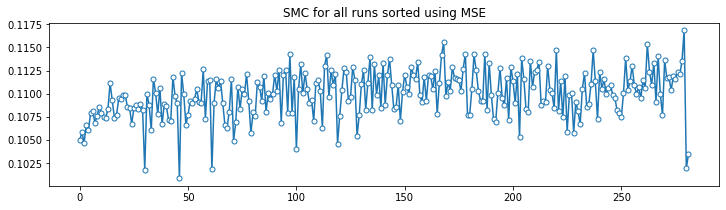

In [41]:
# Check SMC
plt.figure(figsize=(12,3))
plt.plot(tsNMF_results['SMC'][r_idx][run_idx_sorted], '.-', markersize=10, markerfacecolor='w')
plt.title('SMC for all runs sorted using MSE')
# plt.xlim(-1,50)
plt.show()

We can just select the lowest MSE one since it is in the main cluster.

In [42]:
run_idx_sel = run_idx_sorted[0]

In [43]:
# component number sequence matching index
new_comp_seq_idx = match_idx_by_H_NMF[run_idx_sel]  # instead of run_idx_sorted[0]
new_comp_seq_idx

array([2, 0, 1])

In [44]:
# sort and reshape Hs and Ws for display
H_type = 'H_multW'
W_type = 'W_divW'
Ws_reshaped = np.array(tsNMF_results[W_type][r_idx])[run_idx_sel, :, new_comp_seq_idx].\
                reshape(rank_to_check, n_frequencies*n_depth_levels, n_pings)
Hs_reshaped = np.array(tsNMF_results[H_type][r_idx])[run_idx_sel, new_comp_seq_idx, :].T

### Which random seed?

In [45]:
run_idx_sel

260

In [46]:
# run index selected
tsNMF_results['filenum_linenum_original'][r_idx][run_idx_sel]

293

In [47]:
# Double check we can recover that exact run
file_num_sel, line_num_sel = tsNMF_results['filenum_linenum'][r_idx][run_idx_sel]

In [48]:
all_fname[file_num_sel]

'../data/precalc_tsnmf/smoothness_sweep_dict/sm5e6_sp0/ssNMF_sm5e+06_sp0.0_batch16.pkl'

In [49]:
with open(all_fname[file_num_sel],'rb') as openfile:
    x = dill.load(openfile)

In [50]:
W_recover = x[line_num_sel]['W']
H_recover = x[line_num_sel]['H']

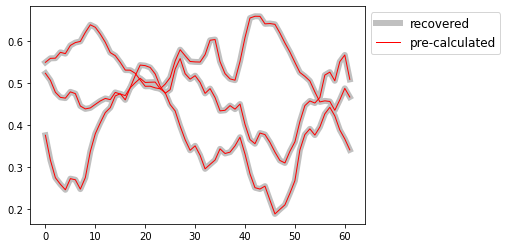

In [51]:
h1 = plt.plot(H_recover.T, color='silver', lw=6)
h2 = plt.plot(tsNMF_results['H'][r_idx][run_idx_sel].T, color='r', lw=1)
plt.legend([h1[0], h2[0]], ['recovered', 'pre-calculated'], fontsize=12, bbox_to_anchor=(1,1))
plt.show()

From the above we know that we can exactly recover this run.

### Sanity check: re-run tsNMF using the random seed

Let's see if we can re-run tsNMF can get the same output when using the same initial condition and early-stopping parameters.

In [52]:
import tsnmf

In [53]:
model = tsnmf.smoothNMF(n_components=3, 
                        max_iter=2000, 
                        smoothness=5000000, 
                        sparsity=0, 
                        early_stopping={'type': 'cost'}
                       )
model.fit(low_rank_nonneg.T, init='random', random_state=2930)

Stopping at iteration 688


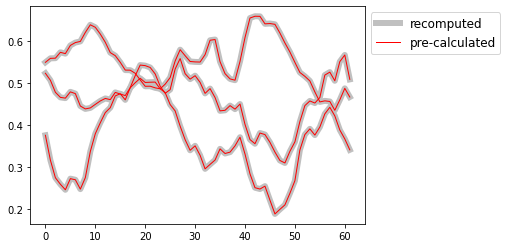

In [54]:
h1 = plt.plot(model.H.T, color='silver', lw=6)
h2 = plt.plot(tsNMF_results['H'][r_idx][run_idx_sel].T, color='r', lw=1)
plt.legend([h1[0], h2[0]], ['recomputed', 'pre-calculated'], fontsize=12, bbox_to_anchor=(1,1))
plt.show()

We have verified that this initial random seed does lead to exactly the same results.